C:\Users\veerk\AppData\Local\Temp\ipykernel_38020\1906527895.py:311: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
c:\Users\veerk\OneDrive\Desktop\DIP Project\dip\Lib\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Starting Multi-Class training on cpu for 5 epochs with 7 classes...


Epoch 1/5 (Train):   0%|          | 0/713 [00:00<?, ?it/s]c:\Users\veerk\OneDrive\Desktop\DIP Project\dip\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\veerk\AppData\Local\Temp\ipykernel_38020\1906527895.py:336: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
c:\Users\veerk\OneDrive\Desktop\DIP Project\dip\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 1/5 (Train): 100%|██████████| 713/713 [22:37<00:00,  1.90s/it]
C:\Users\veerk\AppData\Local\Temp\ipykernel_38020\1906527895.py:83: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with

Epoch 1 finished. Train Loss: 0.5188 | Val Loss: 0.2449 | Val mIoU: 0.5813
Model saved!


Epoch 2/5 (Train): 100%|██████████| 713/713 [23:43<00:00,  2.00s/it]


Epoch 2 finished. Train Loss: 0.3483 | Val Loss: 0.2148 | Val mIoU: 0.5991
Model saved!


Epoch 3/5 (Train): 100%|██████████| 713/713 [24:09<00:00,  2.03s/it]


Epoch 3 finished. Train Loss: 0.3078 | Val Loss: 0.2052 | Val mIoU: 0.6480
Model saved!


Epoch 4/5 (Train): 100%|██████████| 713/713 [23:58<00:00,  2.02s/it]


Epoch 4 finished. Train Loss: 0.2798 | Val Loss: 0.2319 | Val mIoU: 0.6536
Model saved!


Epoch 5/5 (Train): 100%|██████████| 713/713 [24:02<00:00,  2.02s/it]


Epoch 5 finished. Train Loss: 0.2588 | Val Loss: 0.1904 | Val mIoU: 0.6702
Model saved!

--- Generating Visualizations (Multi-Class) ---


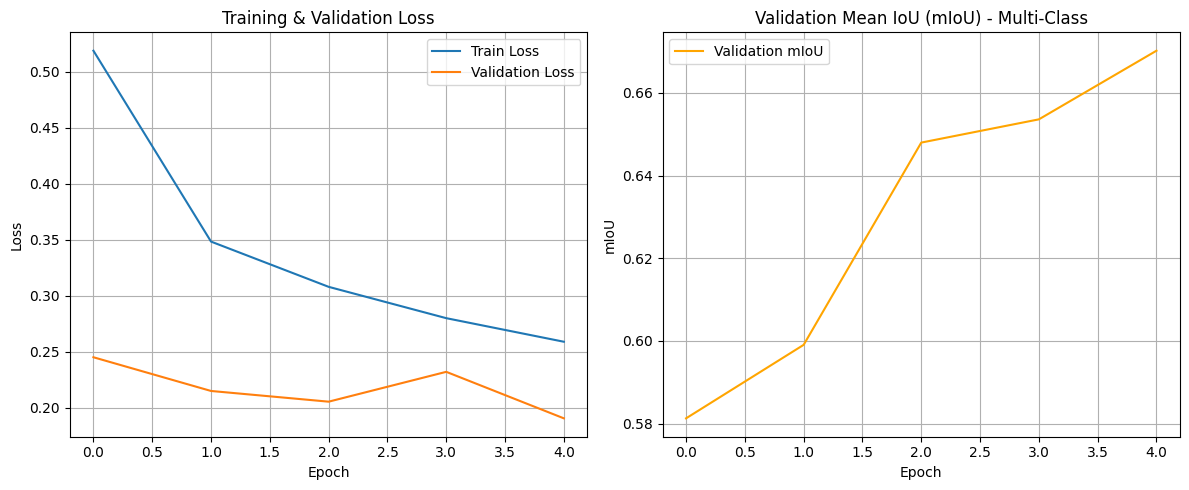

Generated: Training and Validation Curves


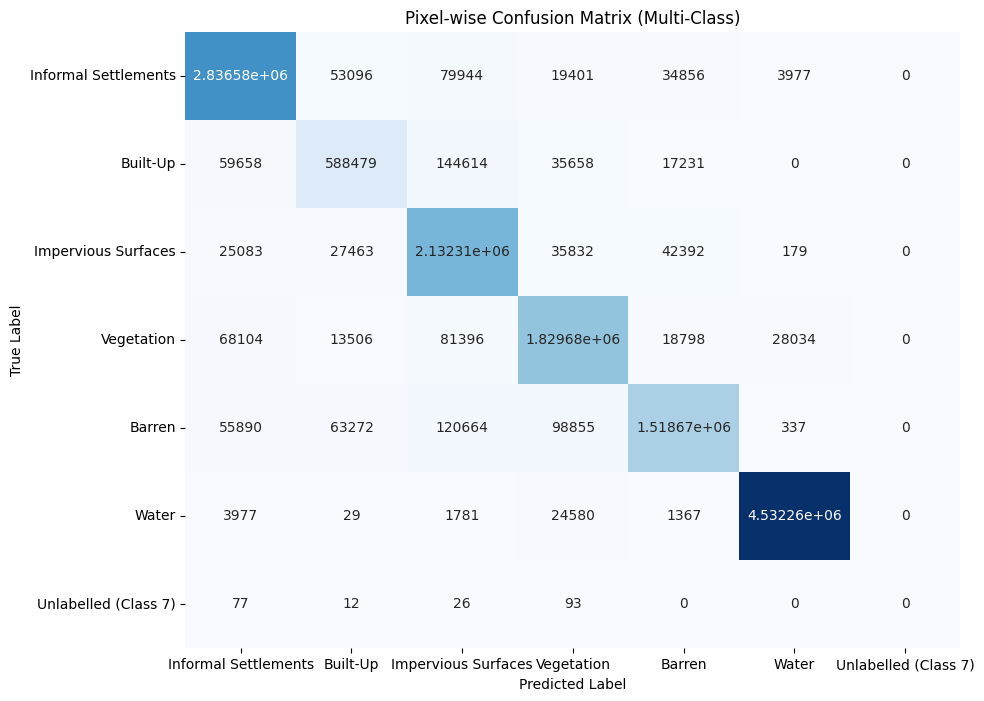

Generated: Confusion Matrix

--- Quantitative Metrics Summary (on Validation Set) ---
Overall Pixel Accuracy: 0.9205
Mean IoU (Jaccard Index) [Macro]: 0.6889
F1-Score [Macro]: 0.7595

--- Per-Class Metrics ---
Class                | Precision  | Recall    
---------------------------------------------
Informal Settlements | 0.9302     | 0.9368    
Built-Up             | 0.7890     | 0.6959    
Impervious Surfaces  | 0.8327     | 0.9421    
Vegetation           | 0.8951     | 0.8971    
Barren               | 0.9298     | 0.8175    
Water                | 0.9929     | 0.9930    
Unlabelled (Class 7) | 0.0000     | 0.0000    


C:\Users\veerk\AppData\Local\Temp\ipykernel_38020\1906527895.py:254: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', NUM_CLASSES)


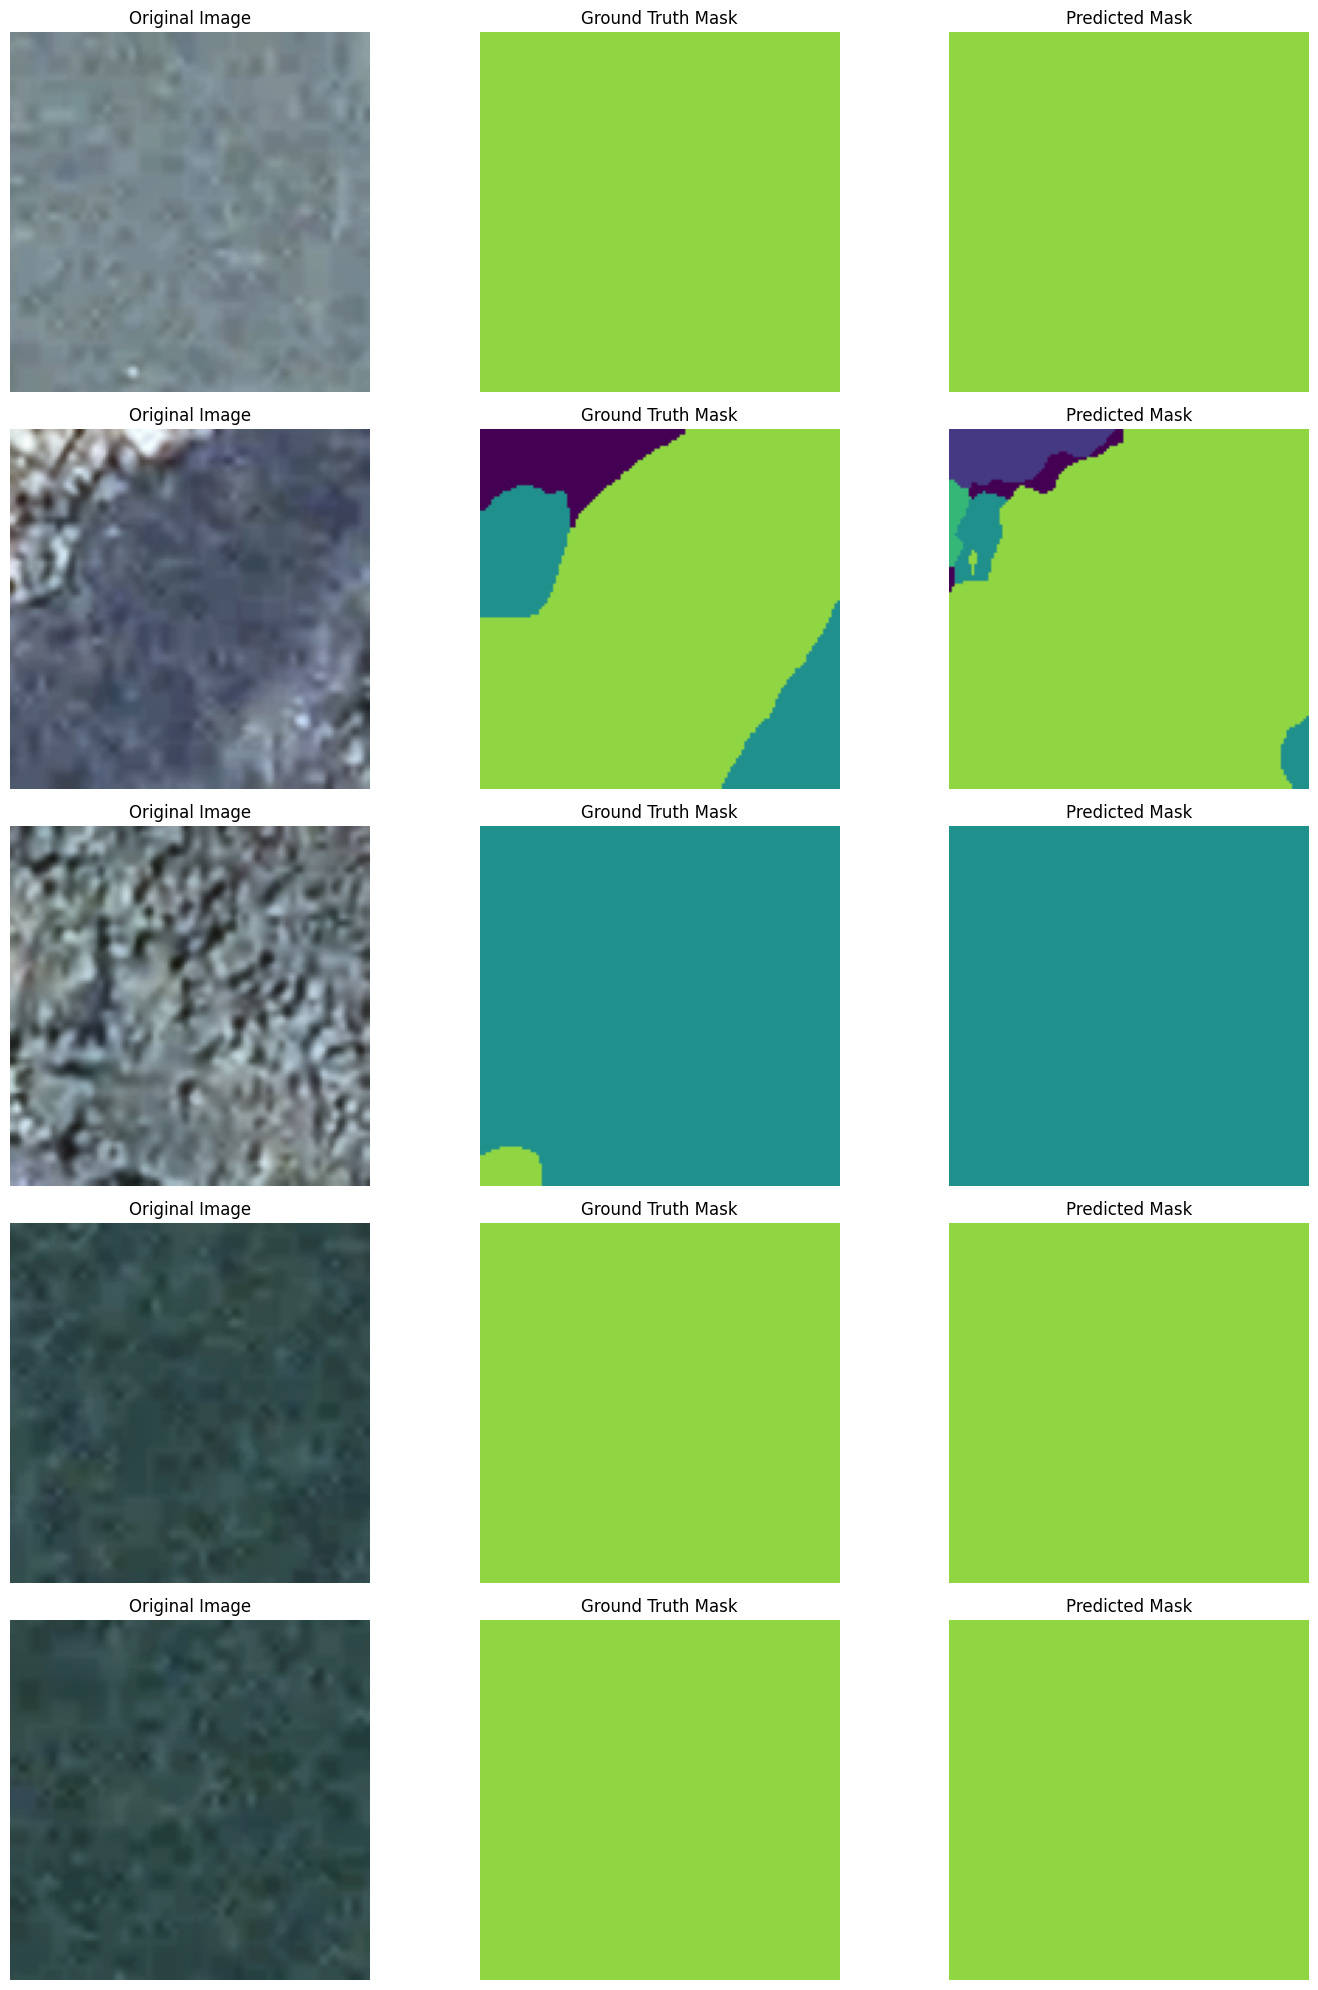

Generated: 5 Visual Segmentation Examples


In [6]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, jaccard_score, precision_score, recall_score, f1_score, accuracy_score

# NOTE: Geoprocessing libraries are kept but will only be useful if specific classes are vectorized.
import rasterio.features
from shapely.geometry import shape

# Import utilities from the other files
from data_utils_7 import SegmentationDataset, enhance_image_dip
# IMPORTANT: get_model, combined_loss, and iou_score MUST be updated in model_utils.py 
# to handle the 7-class multi-class segmentation task.
from model_utils_7 import get_model, combined_loss, iou_score # Assuming these are updated

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 10
NUM_EPOCHS = 5
LR = 1e-4
IMAGE_SIZE = 128 # Define image size for consistency
NUM_CLASSES = 7  # <--- CRITICAL CHANGE: Now 7 classes

# Class Names for visualization (0 is typically background/unlabelled if not explicitly used)
CLASS_NAMES = [
    'Informal Settlements', 'Built-Up', 'Impervious Surfaces', 
    'Vegetation', 'Barren', 'Water', 'Unlabelled (Class 7)'
]
# NOTE: The provided list has 7 names, starting from 1. 
# In multi-class segmentation, the 0-th index is often used, so we'll map the labels 0-6.
# If your masks are 1-7, you MUST map them to 0-6 in SegmentationDataset.

# --- Data Path Placeholders ---
BASE_PATH = "../Dataset/Prepared_Dataset"
TRAIN_IMG_DIR = os.path.join(BASE_PATH, "train/images")
TRAIN_MASK_DIR = os.path.join(BASE_PATH, "train/masks")
VAL_IMG_DIR = os.path.join(BASE_PATH, "val/images")
VAL_MASK_DIR = os.path.join(BASE_PATH, "val/masks")


# --- Augmentations ---
train_transform = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Affine(rotate=(-15,15), scale=(0.9,1.1), translate_percent=(0.06,0.06)),
    A.RandomBrightnessContrast(p=0.5),
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

# --- Evaluation Function (Modified for Multi-Class) ---
def validate_epoch(model, val_loader):
    model.eval()
    val_loss_sum = 0.0
    val_miou_sum = 0.0 # This is now Multi-Class mIoU
    all_preds = []
    all_masks = []
    
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(DEVICE)
            # CRITICAL: Multi-Class masks are typically [B, H, W] with long (integer) labels
            # The original code was: masks.to(DEVICE).squeeze(3).unsqueeze(1) for binary [B, 1, H, W]
            # Now we assume SegmentationDataset loads masks as [H, W, 1] and ToTensorV2 makes it [1, H, W].
            masks = masks.to(DEVICE).squeeze(-1).long() # Should be [B, H, W] and type long/int64
            
            with torch.cuda.amp.autocast():
                logits = model(imgs) # Logits [B, NUM_CLASSES, H, W]
                loss = combined_loss(logits, masks) # Loss function must use LongTensor for masks
            
            val_loss_sum += loss.item() * imgs.size(0)
            
            # CRITICAL: Multi-class prediction is argmax over the class dimension
            preds = torch.argmax(logits, dim=1) # [B, H, W]

            # The iou_score function must also be updated to calculate multi-class mIoU
            val_miou_sum += iou_score(logits, masks, num_classes=NUM_CLASSES) * imgs.size(0)
            
            all_preds.append(preds.cpu().numpy())
            all_masks.append(masks.cpu().numpy())

    avg_loss = val_loss_sum / len(val_loader.dataset)
    avg_miou = val_miou_sum / len(val_loader.dataset)
    
    # Concatenate all predictions and masks
    all_preds = np.concatenate(all_preds, axis=0) # Shape [N, H, W]
    all_masks = np.concatenate(all_masks, axis=0) # Shape [N, H, W]
    
    return avg_loss, avg_miou, all_preds, all_masks


# --- DIP Post-Processing and Vectorization (Now highly specialized for single class) ---
# NOTE: These functions are left here but are ONLY useful for *binary* extraction of one class (e.g., Built-Up).
# To vectorize a specific class, you would need to extract that class's pixels (e.g., class 2) 
# from the multi-class mask and then use these functions.

def post_process_mask_dip(raw_prediction_mask, min_area_threshold=50):
    """
    Applies morphological closing and small object removal to a specific binary mask.
    """
    # ... (Implementation kept the same as it operates on a single channel binary mask) ...
    if raw_prediction_mask.max() <= 1:
        raw_prediction_mask = raw_prediction_mask * 255

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    closed_mask = cv2.morphologyEx(raw_prediction_mask, cv2.MORPH_CLOSE, kernel)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closed_mask, 4, cv2.CV_32S)
    final_mask = np.zeros_like(closed_mask)

    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_area_threshold:
            final_mask[labels == i] = 255

    return final_mask.astype(np.uint8)


def mask_to_polygons(final_mask, transform=None):
    """
    Converts a single-class (binary) cleaned raster mask into Shapely vector polygons.
    """
    # ... (Implementation kept the same) ...
    polygons = []
    # Assumes the single class to vectorize has value 1
    for geom, value in rasterio.features.shapes(final_mask.astype(np.int16), mask=final_mask, transform=transform):
        if value > 0:
            polygons.append(shape(geom))
    return polygons


# --- Sliding Window Inference Sketch (Now Multi-Class) ---
def sliding_window_predict(large_image_path, model, tile_size=120, overlap_ratio=0.5):
    """
    NOTE: In the full multi-class implementation, full_logit_map would be [H, W, NUM_CLASSES].
    This sketch is still heavily simplified.
    """
    print("--- Running Multi-Class Sliding Window Inference Sketch (Simplified) ---")

    img = cv2.imread(large_image_path)
    # H, W, _ = img.shape
    
    # 1. Simulate the multi-class result: a final predicted mask [H, W] with integer class labels
    # Simulating a result:
    H, W = 600, 600 
    full_pred_mask = np.random.randint(0, NUM_CLASSES, size=(H, W), dtype=np.uint8) 

    # 2. To get a single-class vectorization (e.g., for 'Built-Up', which is class 2, index 1)
    target_class_index = 1 
    # Create a binary mask for JUST the target class
    raw_binary_mask_for_vectorization = (full_pred_mask == target_class_index).astype(np.uint8) * 255
    
    # 3. DIP Post-Processing on the chosen class
    cleaned_mask_for_target_class = post_process_mask_dip(raw_binary_mask_for_vectorization)
    
    # 4. Vectorization
    polygons = mask_to_polygons(cleaned_mask_for_target_class, transform=None) 

    print(f"Inference complete. Total {CLASS_NAMES[target_class_index]} polygons found: {len(polygons)}")
    return full_pred_mask, polygons # Return the full mask and the specific polygons


# --- NEW: Plotting Function (Updated for Multi-Class) ---
def plot_results(
    train_losses, val_losses, val_mious,
    all_val_preds, all_val_masks,
    val_dataset,
    num_sample_images=5,
    class_names=CLASS_NAMES
):
    print("\n--- Generating Visualizations (Multi-Class) ---")
    
    # ... (Training & Validation Loss/Metrics Graphs remain the same) ...
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(val_mious, label='Validation mIoU', color='orange')
    plt.title('Validation Mean IoU (mIoU) - Multi-Class')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    print("Generated: Training and Validation Curves")
    
    # --- 2. Confusion Matrix (Multi-Class) ---
    # Flatten the masks and predictions for confusion matrix calculation
    # all_val_masks and all_val_preds are [N, H, W], so flatten to [N*H*W]
    flat_true = all_val_masks.flatten()
    flat_pred = all_val_preds.flatten()
    
    cm = confusion_matrix(flat_true, flat_pred, labels=np.arange(NUM_CLASSES))
    
    plt.figure(figsize=(10, 8)) # Increased size for 7 classes
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Pixel-wise Confusion Matrix (Multi-Class)')
    plt.show()
    print("Generated: Confusion Matrix")

    # --- 3. Quantitative Metrics Summary (Table) ---
    overall_accuracy = accuracy_score(flat_true, flat_pred)
    # For Multi-Class, use 'macro' or 'weighted' for mIoU/F1
    overall_miou_macro = jaccard_score(flat_true, flat_pred, average='macro', zero_division=0) 
    f1_macro = f1_score(flat_true, flat_pred, average='macro', zero_division=0)
    
    print("\n--- Quantitative Metrics Summary (on Validation Set) ---")
    print(f"Overall Pixel Accuracy: {overall_accuracy:.4f}")
    print(f"Mean IoU (Jaccard Index) [Macro]: {overall_miou_macro:.4f}")
    print(f"F1-Score [Macro]: {f1_macro:.4f}")

    # You can also use precision_score, recall_score with average='None' to get per-class metrics
    precision_per_class = precision_score(flat_true, flat_pred, average=None, labels=np.arange(NUM_CLASSES), zero_division=0)
    recall_per_class = recall_score(flat_true, flat_pred, average=None, labels=np.arange(NUM_CLASSES), zero_division=0)
    
    print("\n--- Per-Class Metrics ---")
    print(f"{'Class':<20} | {'Precision':<10} | {'Recall':<10}")
    print("-" * 45)
    for i in range(NUM_CLASSES):
        print(f"{class_names[i]:<20} | {precision_per_class[i]:<10.4f} | {recall_per_class[i]:<10.4f}")


    # --- 4. Visual Examples of Segmentation ---
    # NOTE: You'll need a color map to visualize multi-class masks, as grayscale won't be enough.
    cmap = plt.cm.get_cmap('viridis', NUM_CLASSES) 
    plt.figure(figsize=(15, num_sample_images * 4)) 
    sample_indices = np.random.choice(len(val_dataset), num_sample_images, replace=False)
    
    for i, idx in enumerate(sample_indices):
        original_img_tensor, true_mask_tensor = val_dataset[idx]
        
        # Denormalize image for display
        img_display = original_img_tensor.permute(1, 2, 0).numpy() # CHW to HWC
        mean = np.array([0.485,0.456,0.406])
        std = np.array([0.229,0.224,0.225])
        img_display = std * img_display + mean
        img_display = np.clip(img_display, 0, 1)

        true_mask_display = true_mask_tensor.squeeze().numpy() # [H, W]
        predicted_mask_display = all_val_preds[idx].squeeze()  # [H, W]

        plt.subplot(num_sample_images, 3, i * 3 + 1)
        plt.imshow(img_display)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_sample_images, 3, i * 3 + 2)
        plt.imshow(true_mask_display, cmap=cmap, vmin=0, vmax=NUM_CLASSES-1)
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(num_sample_images, 3, i * 3 + 3)
        plt.imshow(predicted_mask_display, cmap=cmap, vmin=0, vmax=NUM_CLASSES-1)
        plt.title('Predicted Mask')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()
    print(f"Generated: {num_sample_images} Visual Segmentation Examples")


# --- Main Execution ---
def main():
    if not os.path.exists(TRAIN_IMG_DIR) or not os.path.exists(VAL_IMG_DIR):
        print("!! ERROR: Please ensure data paths are correct and the dataset is downloaded/extracted.")
        print(f"Expected path: {BASE_PATH}")
        return 

    # 1. DataLoaders
    train_dataset = SegmentationDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, transform=train_transform)
    val_dataset = SegmentationDataset(VAL_IMG_DIR, VAL_MASK_DIR, transform=val_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    
    # 2. Model, Optimizer, Scheduler
    # CRITICAL: get_model(NUM_CLASSES) should be called if it takes the number of classes as an argument.
    # Assuming get_model has been updated to use NUM_CLASSES=7.
    model = get_model(DEVICE) 
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, mode='max')
    scaler = torch.cuda.amp.GradScaler()

    best_miou = 0.0
    
    train_losses_history = []
    val_losses_history = []
    val_mious_history = []
    
    final_val_preds = None
    final_val_masks = None

    # 3. Training Loop
    print(f"Starting Multi-Class training on {DEVICE} for {NUM_EPOCHS} epochs with {NUM_CLASSES} classes...")
    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        train_loss = 0.0
        
        # Training
        for batch_idx, (imgs, masks) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} (Train)")):
            imgs = imgs.to(DEVICE)
            # CRITICAL: Mask handling changed for multi-class [B, H, W]
            masks = masks.to(DEVICE).squeeze(-1).long() # [B, H, W] of type torch.long
            
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                logits = model(imgs) # [B, 7, H, W]
                loss = combined_loss(logits, masks) # Must use multi-class loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item() * imgs.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses_history.append(avg_train_loss) 

        # Validation
        val_loss, val_miou, current_epoch_preds, current_epoch_masks = validate_epoch(model, val_loader)
        val_losses_history.append(val_loss) 
        val_mious_history.append(val_miou)  
        
        # Store predictions and masks from the LAST epoch for final confusion matrix/metrics
        final_val_preds = current_epoch_preds
        final_val_masks = current_epoch_masks

        scheduler.step(val_miou)

        print(f"Epoch {epoch} finished. Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val mIoU: {val_miou:.4f}")

        # Save best model
        if val_miou > best_miou:
            best_miou = val_miou
            torch.save(model.state_dict(), "best_model.pth")
            print("Model saved!")
            # Save predictions from the best model epoch
            final_val_preds = current_epoch_preds
            final_val_masks = current_epoch_masks


    # 4. Generate and Plot Results
    # Load the best model weights if the last epoch was not the best
    if not os.path.exists("best_model.pth"):
        print("Warning: best_model.pth not found. Using last epoch model state.")
    else:
        model.load_state_dict(torch.load("best_model.pth"))
        # Re-run evaluation on the best model to ensure final_val_preds/masks are correct
        _, _, final_val_preds, final_val_masks = validate_epoch(model, val_loader)


    plot_results(
        train_losses_history,
        val_losses_history,
        val_mious_history,
        final_val_preds,
        final_val_masks,
        val_dataset,
        num_sample_images=5 
    )
            
    # 5. Optional: Inference and Post-processing (using the best model)
    # print("\n--- Starting Optional Multi-Class Inference and Post-processing Sketch ---")
    # SAMPLE_LARGE_IMAGE_PATH = "path/to/your/full_patch_test_image.png"
    # if os.path.exists(SAMPLE_LARGE_IMAGE_PATH):
    #     # The result here is the full multi-class prediction mask and polygons for a single class (Built-Up)
    #     full_pred_mask, polygons = sliding_window_predict(SAMPLE_LARGE_IMAGE_PATH, model)
    # else:
    #     print(f"Warning: Could not run full inference. Image path not found: {SAMPLE_LARGE_IMAGE_PATH}")

if __name__ == '__main__':
    try:
        main()
    except AssertionError as e:
        print(f"Fatal Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}. Check if model_utils.py functions (get_model, combined_loss, iou_score) support NUM_CLASSES=7 multi-class segmentation.")